<h1>Deep Learning with PyTorch : Siamese Network</h1>

<h2>Siamese Network

<h3>Download and Import libraries

In [2]:
!pip instaLWP:Sll segmentation-models-pytorch -q
!pip install -U git+https://github.com/albumentations-team/albumentations -q
!pip install --upgrade opencv-contrib-python -q

ERROR: unknown command "instaLWP:Sll" - maybe you meant "install"


In [3]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 28.26 MiB/s, done.


In [4]:
import sys
sys.path.append("/kaggle/working/Person-Re-Id-Dataset")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

"""
Timm: PyTorch Image Models (timm) is a library for state-of-the-art-image classification, containing a collection of image models, optimizers, schedulers, augmentations and much more.
"""
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

"""
tqdm is a library that is used for creating Python Progress Bars. It gets its name from the Arabic name taqaddum, which means 'progress. '
"""
from tqdm import tqdm

<h3>Configurations

In [7]:
DATA_DIR = "/kaggle/input/market-1501/Market-1501-v15.09.15/bounding_box_train/"
CSV_FILE = "/kaggle/working/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[11]



A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

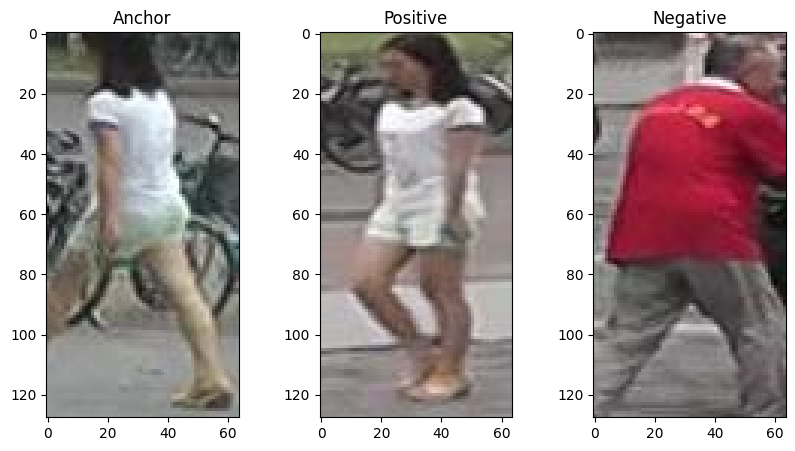

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

<h3>Create APN Dataset

In [12]:
class APN_Dataset(Dataset):
    
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)
        
        A_img = torch.from_numpy(A_img).permute(2, 0 ,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0 ,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0 ,1) / 255.0
        
        return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


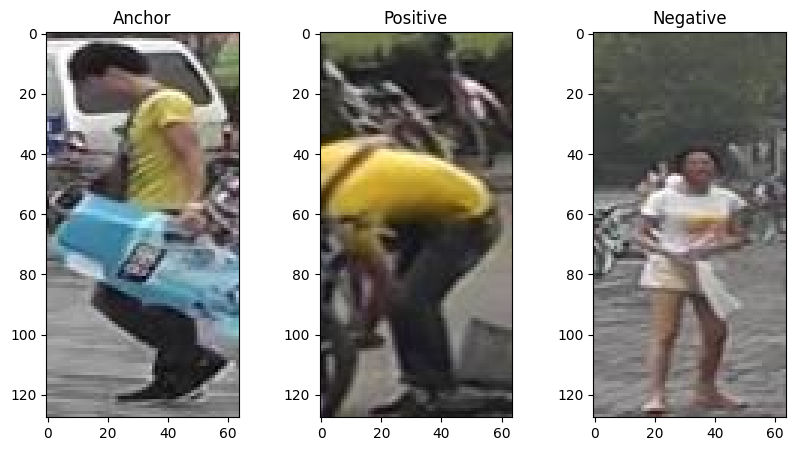

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

<h3>Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
    break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


<h3>Create Model

In [18]:
class APN_Model(nn.Module):
    
    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()
        
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                                out_features = emb_size)
        
    
    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [19]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

<h3>Create Train and Eval Function

In [20]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train() # ON Dropout
    total_loss = 0.0 
    
    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
        
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        
        loss = criterion(A_embs, P_embs, N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [21]:
def eval_fn(model, dataloader, criterion):
    model.eval()  # OFF Dropout
    total_loss = 0.0 
    
    with torch.no_grad():
        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()
        
        return total_loss / len(dataloader)

In [22]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

<h3>Create Training Loop

In [23]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")
    
    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.6458474239706993 valid_loss: 0.5300906217098236


100%|██████████| 25/25 [00:04<00:00,  6.10it/s]]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 0.2918493527173996 valid_loss: 0.3624643415212631


100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 3 train_loss: 0.16044778406620025 valid_loss: 0.1662741023302078


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


EPOCHS: 4 train_loss: 0.10664344549179078 valid_loss: 0.1862213307619095


100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


EPOCHS: 5 train_loss: 0.09449839115142822 valid_loss: 0.23445645928382874


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


EPOCHS: 6 train_loss: 0.07613637045025826 valid_loss: 0.22212576419115065


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


EPOCHS: 7 train_loss: 0.07185370206832886 valid_loss: 0.19353161215782166


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


EPOCHS: 8 train_loss: 0.052222622632980345 valid_loss: 0.16747596621513366


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 9 train_loss: 0.060080961436033246 valid_loss: 0.16020803213119506


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 10 train_loss: 0.030249001160264015 valid_loss: 0.14729755163192748


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 11 train_loss: 0.024793661832809448 valid_loss: 0.13383762985467912


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


EPOCHS: 12 train_loss: 0.06371600657701493 valid_loss: 0.20445127964019774


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


EPOCHS: 13 train_loss: 0.032063273191452024 valid_loss: 0.1712493896484375


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


EPOCHS: 14 train_loss: 0.02428630992770195 valid_loss: 0.17159552097320557


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]

EPOCHS: 15 train_loss: 0.028097160905599595 valid_loss: 0.1840119743347168


<h3>Get Anchor Embeddings

In [24]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        
        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)
    
    return df_enc

In [25]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:38<00:00, 102.62it/s]


In [26]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.447164,-0.196740,-0.401624,0.217036,0.252575,-0.069746,0.094910,0.855470,0.545852,...,-0.368841,-0.927328,0.451895,-0.289989,-0.467675,-0.467371,-0.101328,-0.214083,-0.188504,-0.010613
1,1420_c3s3_061978_03.jpg,-0.384470,-0.323656,-0.437422,0.224728,0.293815,-0.347753,0.386250,0.681066,0.395071,...,-0.125462,-0.537793,0.212813,-0.187841,-0.780947,-0.534343,-0.044615,-0.210852,-0.478965,-0.067075
2,1420_c5s3_062565_05.jpg,-0.296172,-0.371538,-0.414034,-0.255159,0.118479,-0.444383,0.384441,0.827342,0.407934,...,-0.039343,-0.736249,0.323637,-0.237561,-0.702651,-0.125960,-0.064979,0.001072,-0.496539,-0.427864
3,1420_c6s3_085592_04.jpg,0.064139,-0.437729,-0.514970,-0.022136,0.532331,0.056873,0.254911,0.925798,0.566853,...,-0.337614,-0.748578,0.225830,-0.046512,-0.638869,-0.775619,-0.189818,-0.097227,0.088704,-0.306203
4,0663_c5s3_085987_03.jpg,0.326953,0.403806,0.107870,-0.242778,0.441626,0.796713,-0.780078,-0.279285,-0.156392,...,-0.421177,-0.098366,-0.188928,-0.081861,0.980356,-0.081516,0.364790,0.574042,0.612254,0.059917


<h3>Inference

In [27]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [28]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [29]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [30]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [31]:
closest_idx = np.argsort(distance)

/opt/conda/lib/python3.10/site-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


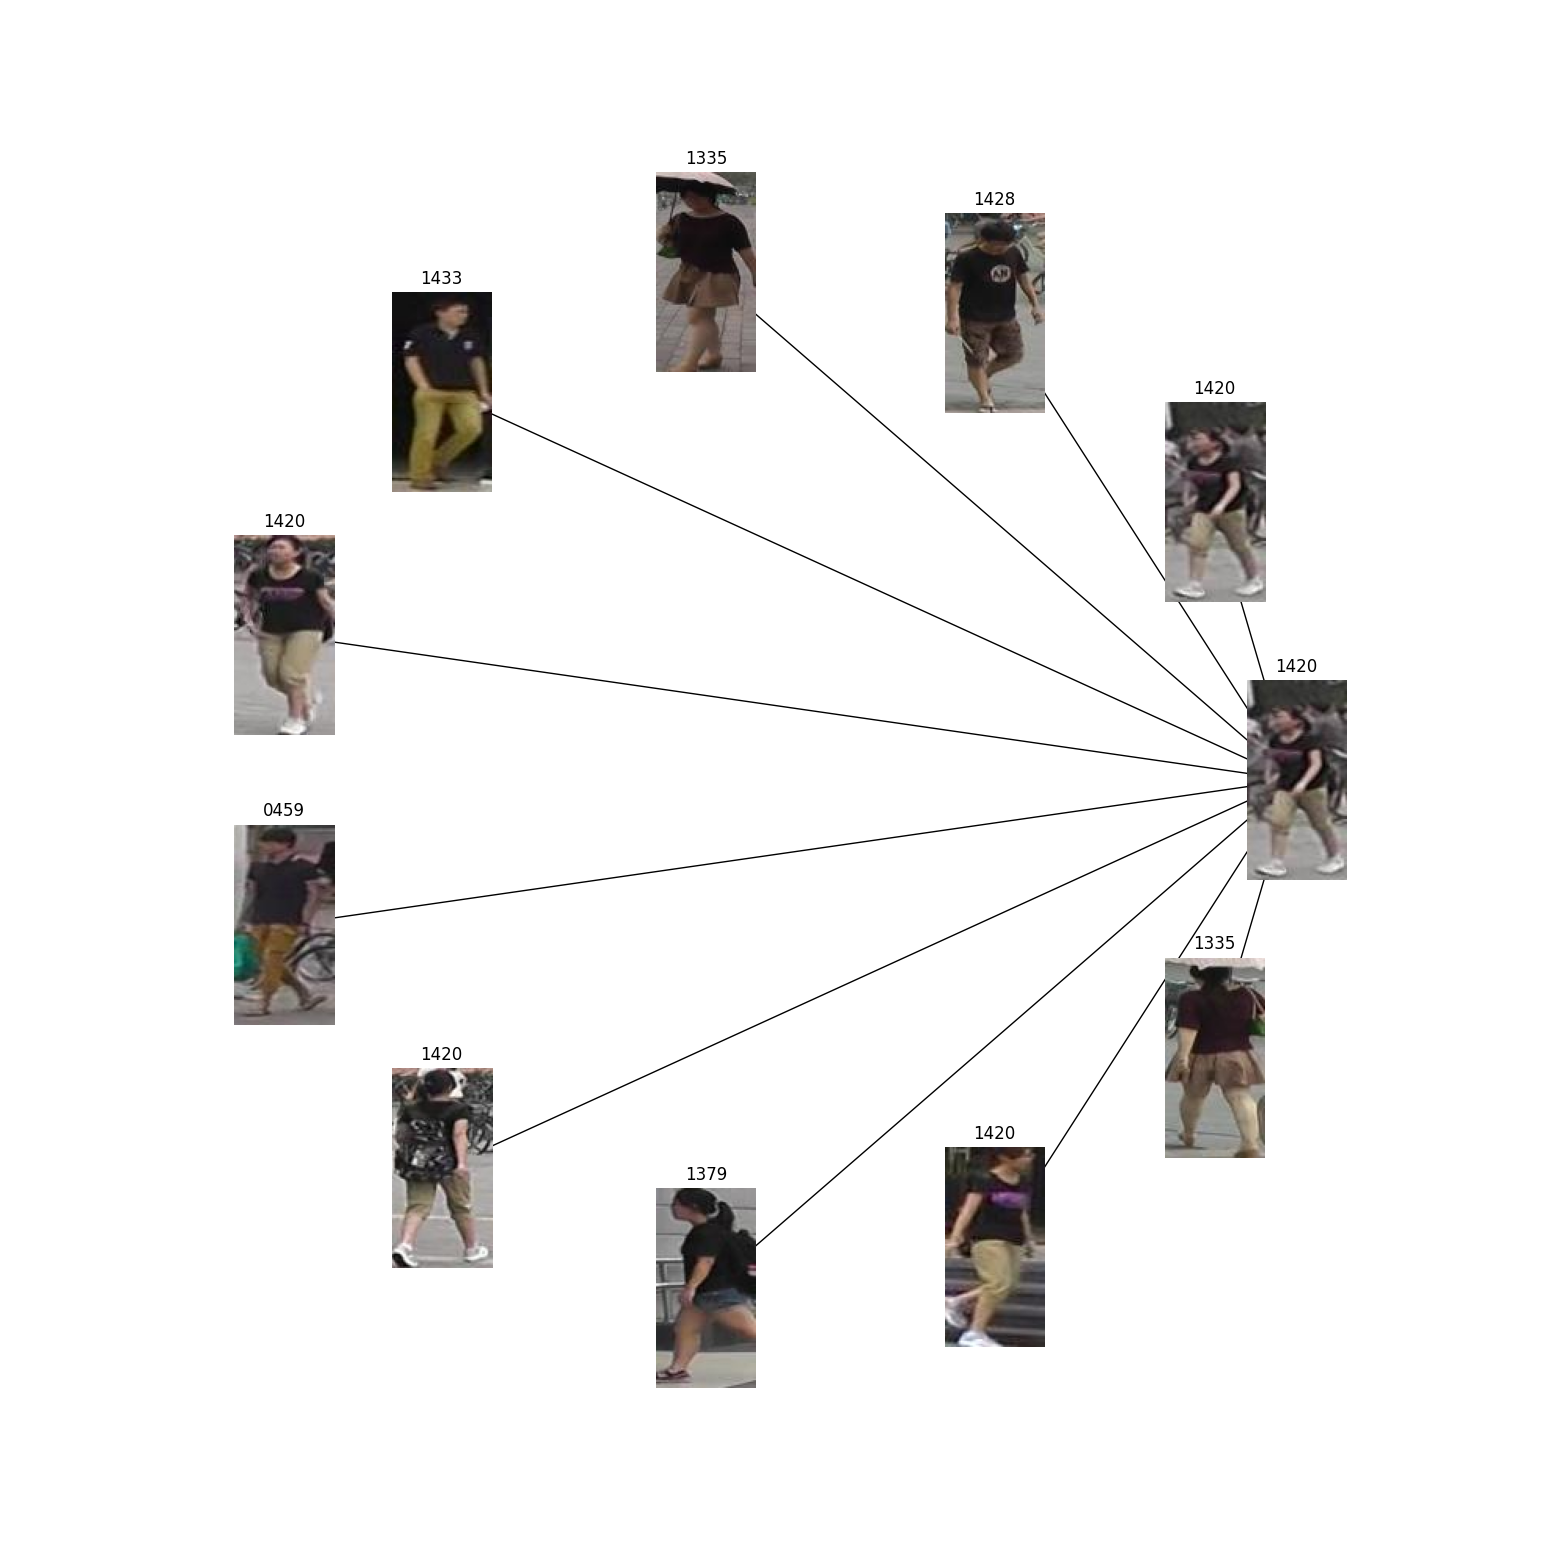

In [32]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);